<a href="https://colab.research.google.com/github/zergswim/Diffusion/blob/main/DiffusionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                          transform=torchvision.transforms.ToTensor())
mnist_train, mnist_val = random_split(mnist_train, [500, 59500])

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=32)

class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(

            # nn.Conv2d(1, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64, track_running_stats = False),
            # nn.ReLU(),
            # nn.Conv2d(64, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256, track_running_stats = False),
            # nn.ReLU(),

            # nn.MaxPool2d(2),

            # nn.Flatten(),
            # nn.Linear(in_features=50176, out_features=784),

            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        ).to(device)

        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        ).to(device)

        self.time_mlp = nn.Sequential(
            nn.Linear(1, 784),
            nn.ReLU()
        ).to(device)

    def forward(self, x, t):
        # x = x.view(x.size(0), 1, 28, 28)  # 입력 x를 reshape
        x = x.view(x.size(0), -1)  # 입력 x를 평탄화합니다.
        # x = self.pos_encoding(x, t) #pos 인코딩 생략
        z = self.encoder(x)

        # z = z.view(z.size(0), -1)  # 입력 x를 평탄화합니다.
        x_hat = self.decoder(z)
        return x_hat

    # def pos_encoding(self, x, t):
    #     t = torch.FloatTensor([t*0.1]*x.size(0))
    #     t = t.view(x.size(0), 1)
    #     t = self.time_mlp(t)
    #     x = torch.cat([x, t], dim=-1)
    #     return t

def train(model, noise_fn, epochs, steps=10):
  optimizer = torch.optim.Adam(model.parameters())

  from skimage.util import random_noise

  # 모델 사전 학습
  for epoch in range(epochs):
      # model.train()
      for batch in train_loader:
          images, _ = batch
          images = images.to(device)
          images_flat = images.view(images.size(0), -1)
          noise_flat = images_flat

          noise_list = []
          #정방향(단계별 노이즈 추가)
          for r in range(10):
            noise_flat = noise_fn(noise_flat, var=0.1)
            noise_list.append(noise_flat)

          # input_img = noise_list[9]

          #역방향(단계별 노이즈 제거 학습)
          for r in range(9, 0, -1):
            # reconstructed = model(noise_flat, r)
            # loss = F.mse_loss(reconstructed, noise_flat)

            reconstructed = model(noise_list[r], r)
            loss = F.mse_loss(noise_list[r-1], reconstructed)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # input_img = reconstructed.detach()

      print(f"Epoch {epoch}, Loss: {loss.item()}")

      if epoch%10 == 0:
        displayManifold()

def restore_images(model, origin, noise_fn):
  origin = origin.to(device)

  with torch.no_grad():
      origin_flat = origin.view(origin.size(0), -1)
      origin_reconstructed = model(origin_flat, 9)

      noise_flat = origin_flat

      plt.figure(figsize=(15,15))
      display(origin_flat[0].cpu().reshape(28, 28), 'original', 1)

      for r in range(10):
        noise_flat = noise_fn(noise_flat, var=0.1)
        display(noise_flat[0].cpu().reshape(28, 28), f'step {r}', r+2)

      plt.show()

      # noisy_img = noise_fn(img_flat, var=0.9) #랜덤 노이즈 이미지

      plt.figure(figsize=(15,15))
      display(noise_flat[0].cpu().reshape(28, 28), 'noise', 1)

      for r in range(10):
        noise_flat = model(noise_flat, r)
        display(noise_flat[0].cpu().reshape(28, 28), f'step {r}', r+2)

      plt.show()

def display(img, title, loc):
  plt.subplot(1, 12, loc)
  plt.imshow(img, cmap="gray")
  plt.axis('off')
  plt.title(title)

import numpy as np

def displayManifold():
  # display a 2D manifold of the digits
  n = 15  # figure with 15x15 digits
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
  # to produce values of the latent variables z, since the prior of the latent space is Gaussian
  from scipy.stats import norm
  grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
  grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

  for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
          z_sample = np.array([[xi, yi]])
          x_decoded = model.decoder(torch.Tensor(z_sample))
          digit = x_decoded[0].detach().reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(10, 10))
  plt.imshow(figure, cmap='Greys_r')
  plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 81095331.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62960339.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30681114.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15313929.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 0, Loss: 0.0962197333574295


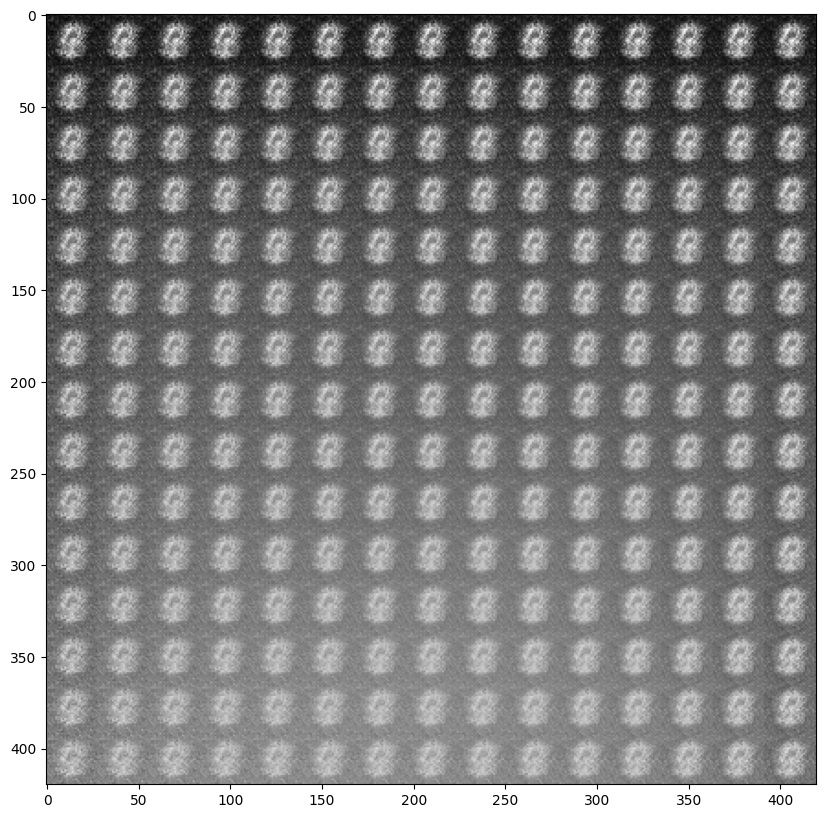

Epoch 1, Loss: 0.07691916078329086
Epoch 2, Loss: 0.07574708014726639
Epoch 3, Loss: 0.07067236304283142
Epoch 4, Loss: 0.07795926928520203
Epoch 5, Loss: 0.08213305473327637
Epoch 6, Loss: 0.07081343233585358
Epoch 7, Loss: 0.07519995421171188
Epoch 8, Loss: 0.07514039427042007
Epoch 9, Loss: 0.0728287324309349
Epoch 10, Loss: 0.07064326852560043


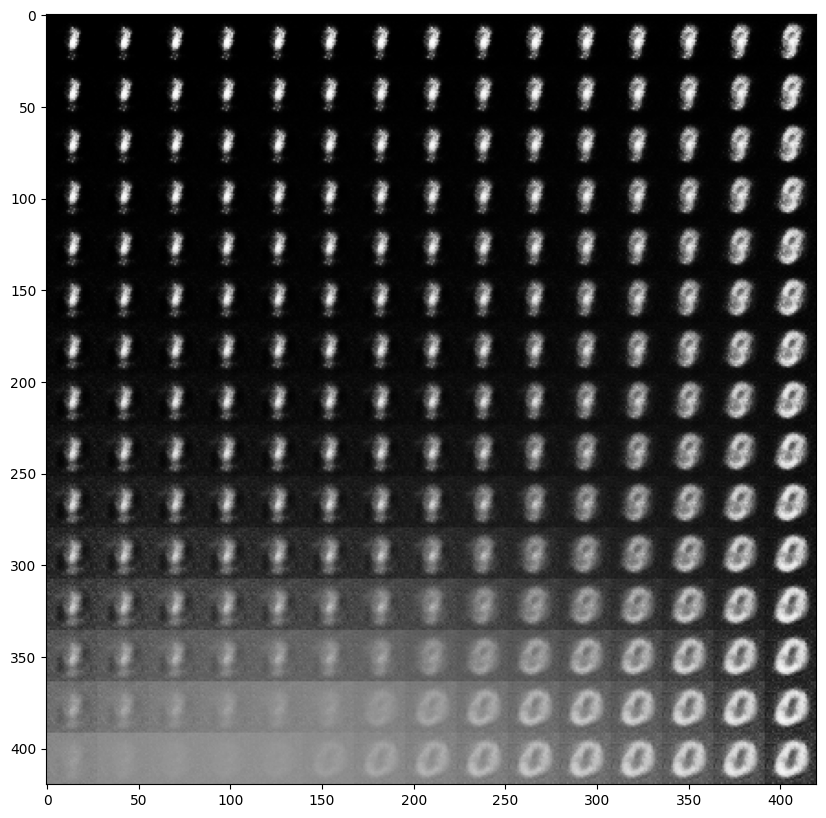

Epoch 11, Loss: 0.07521779835224152
Epoch 12, Loss: 0.07581167668104172
Epoch 13, Loss: 0.07100608199834824
Epoch 14, Loss: 0.07141868770122528
Epoch 15, Loss: 0.07314606010913849
Epoch 16, Loss: 0.07029067724943161
Epoch 17, Loss: 0.07281596958637238
Epoch 18, Loss: 0.07860185950994492
Epoch 19, Loss: 0.06960538774728775
Epoch 20, Loss: 0.06764892488718033


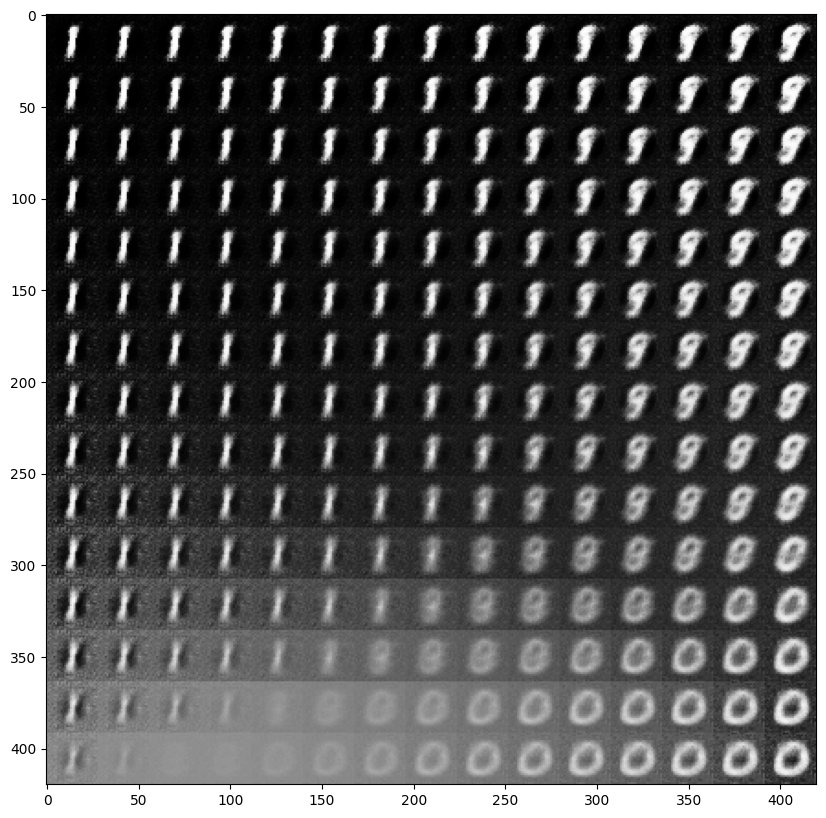

Epoch 21, Loss: 0.07186417281627655
Epoch 22, Loss: 0.07725577801465988
Epoch 23, Loss: 0.07153753191232681
Epoch 24, Loss: 0.06886185705661774
Epoch 25, Loss: 0.07107575982809067
Epoch 26, Loss: 0.06681942939758301
Epoch 27, Loss: 0.06781814992427826
Epoch 28, Loss: 0.07028067111968994
Epoch 29, Loss: 0.06712710857391357
Epoch 30, Loss: 0.07049058377742767


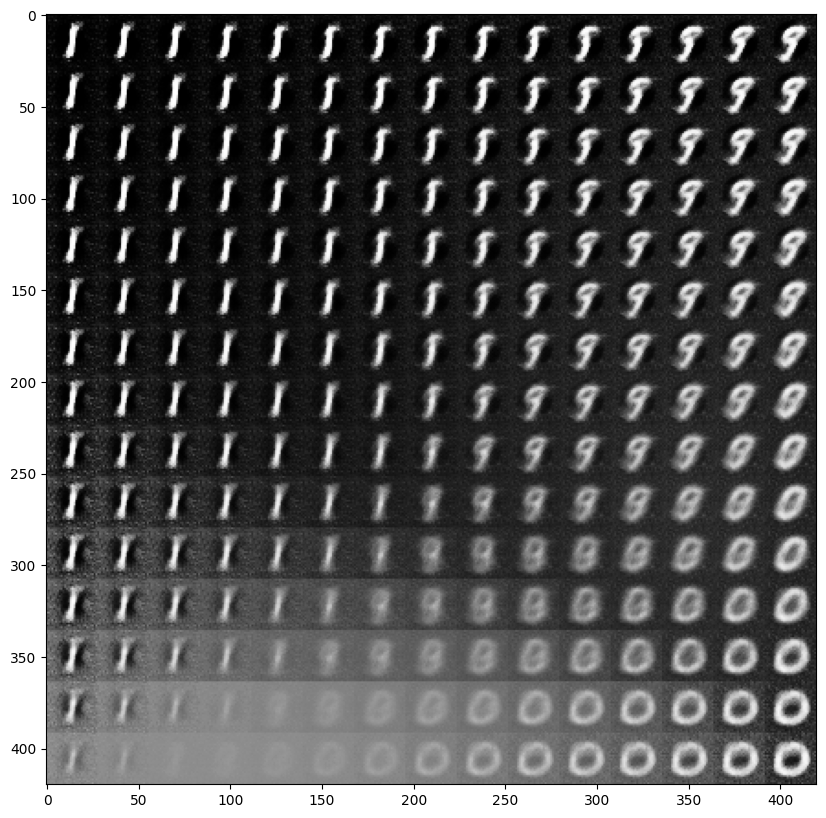

Epoch 31, Loss: 0.07086407393217087
Epoch 32, Loss: 0.07171753793954849
Epoch 33, Loss: 0.07083483040332794
Epoch 34, Loss: 0.07026338577270508
Epoch 35, Loss: 0.06753241270780563
Epoch 36, Loss: 0.07192428410053253
Epoch 37, Loss: 0.06836596131324768
Epoch 38, Loss: 0.07262668013572693
Epoch 39, Loss: 0.06537850946187973


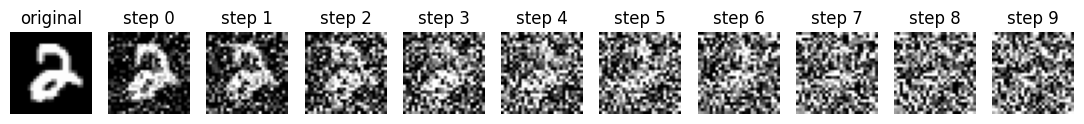

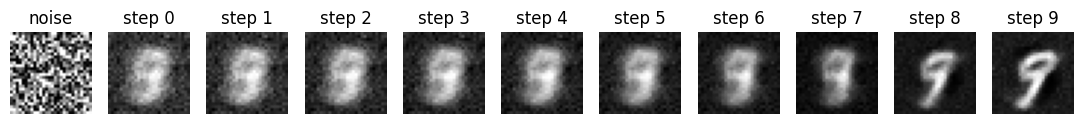

In [2]:
from skimage.util import random_noise

def random_noise_fn(img_flat, var=0.1):
  return torch.Tensor(random_noise(img_flat, var=var))

model = Diffusion().to(device)
train(model, random_noise_fn, 40) #랜덤 노이즈로 학습
# model.eval()

# 잡음 추가 및 재구성
origin, _ = next(iter(val_loader))
restore_images(model, origin, random_noise_fn)

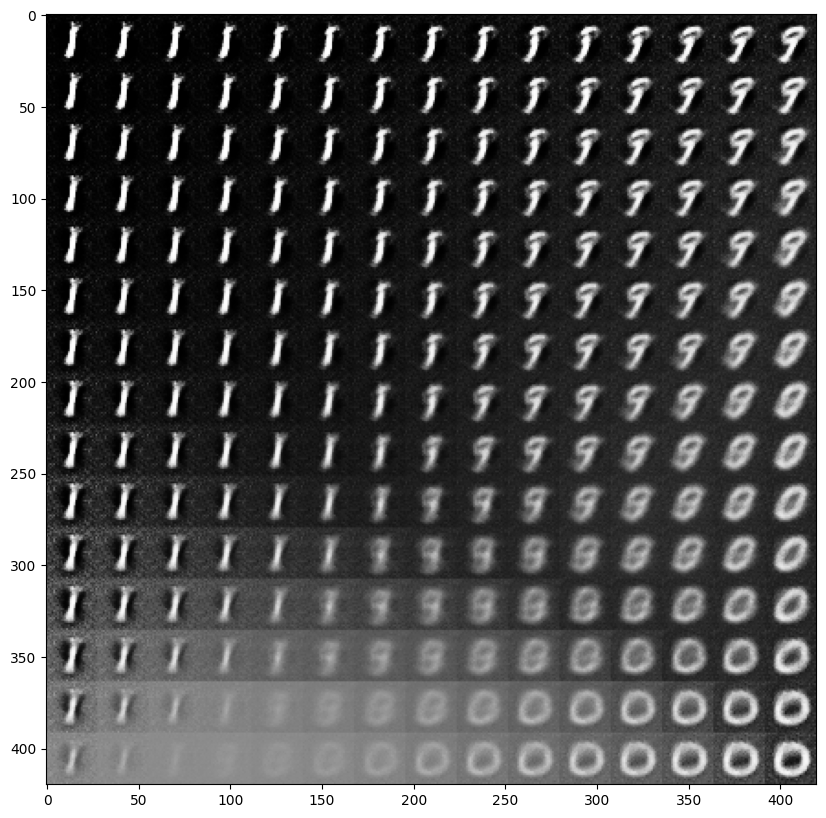

In [3]:
displayManifold()

Epoch 0, Loss: 0.0793992206454277


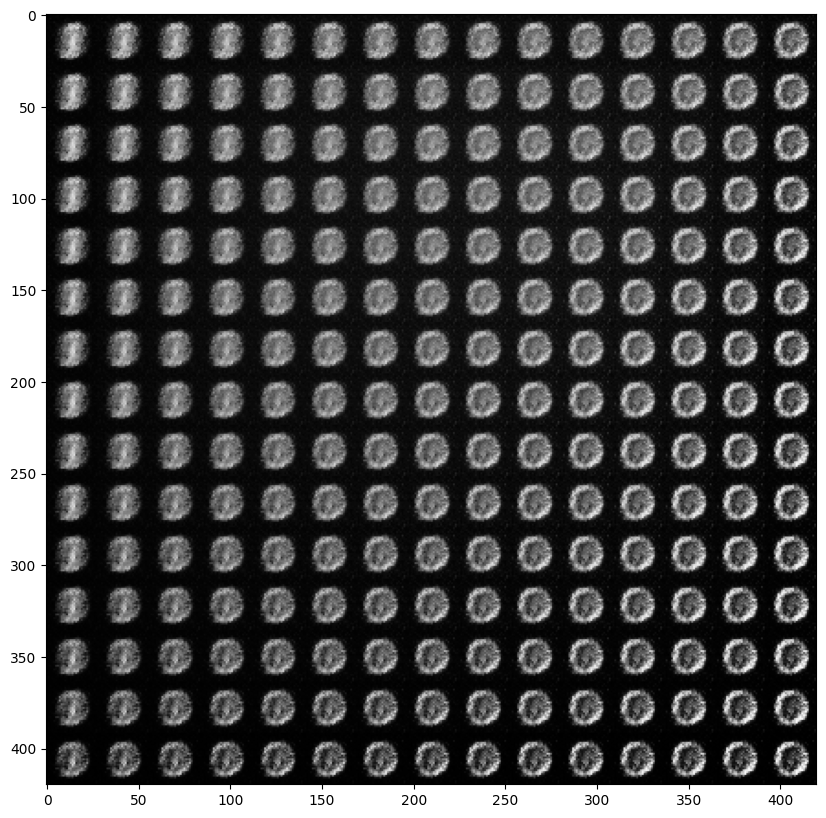

Epoch 1, Loss: 0.07417880743741989
Epoch 2, Loss: 0.08056811988353729
Epoch 3, Loss: 0.07663170993328094
Epoch 4, Loss: 0.08008018136024475
Epoch 5, Loss: 0.07789548486471176
Epoch 6, Loss: 0.0722326710820198
Epoch 7, Loss: 0.07000390440225601
Epoch 8, Loss: 0.0679759830236435
Epoch 9, Loss: 0.07253111898899078
Epoch 10, Loss: 0.07007783651351929


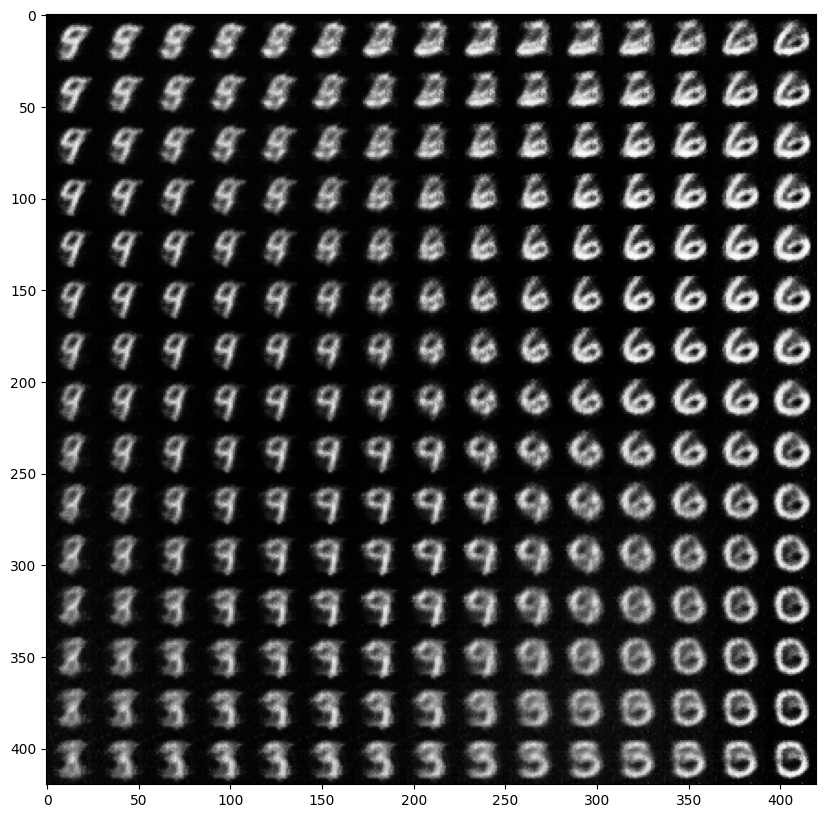

Epoch 11, Loss: 0.07216046750545502
Epoch 12, Loss: 0.06073411554098129
Epoch 13, Loss: 0.06678377836942673
Epoch 14, Loss: 0.06775195151567459
Epoch 15, Loss: 0.06403084099292755
Epoch 16, Loss: 0.06584025919437408
Epoch 17, Loss: 0.062335699796676636
Epoch 18, Loss: 0.07358164340257645
Epoch 19, Loss: 0.06976086646318436
Epoch 20, Loss: 0.06333485245704651


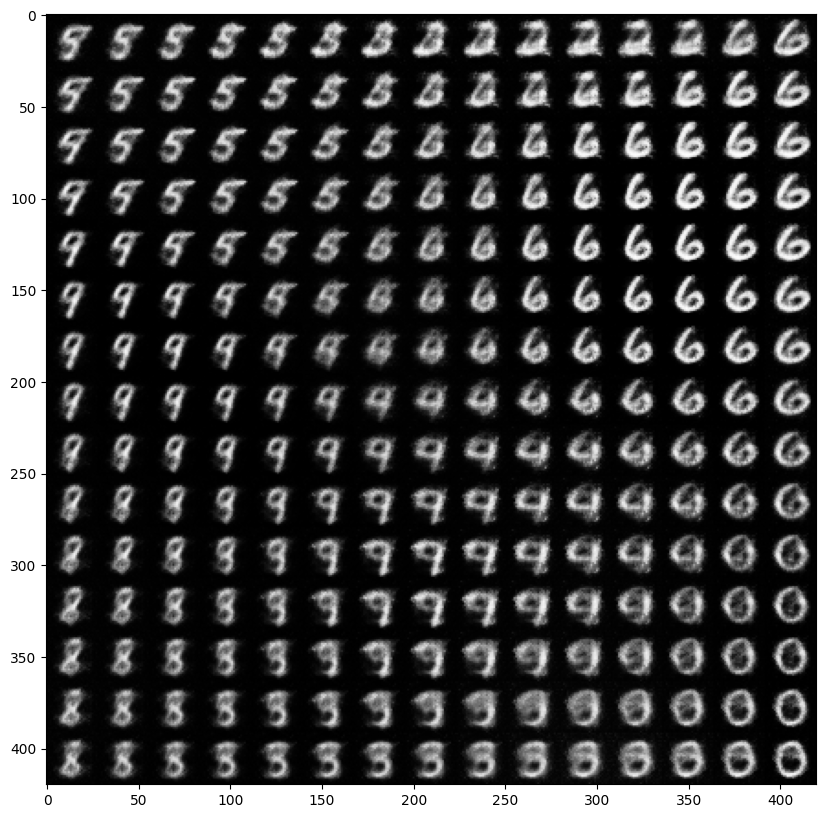

Epoch 21, Loss: 0.06796567142009735
Epoch 22, Loss: 0.06665793806314468
Epoch 23, Loss: 0.06004352122545242
Epoch 24, Loss: 0.06300187110900879
Epoch 25, Loss: 0.07309234142303467
Epoch 26, Loss: 0.06892916560173035
Epoch 27, Loss: 0.05866643041372299
Epoch 28, Loss: 0.06810256093740463
Epoch 29, Loss: 0.055702030658721924
Epoch 30, Loss: 0.06660139560699463


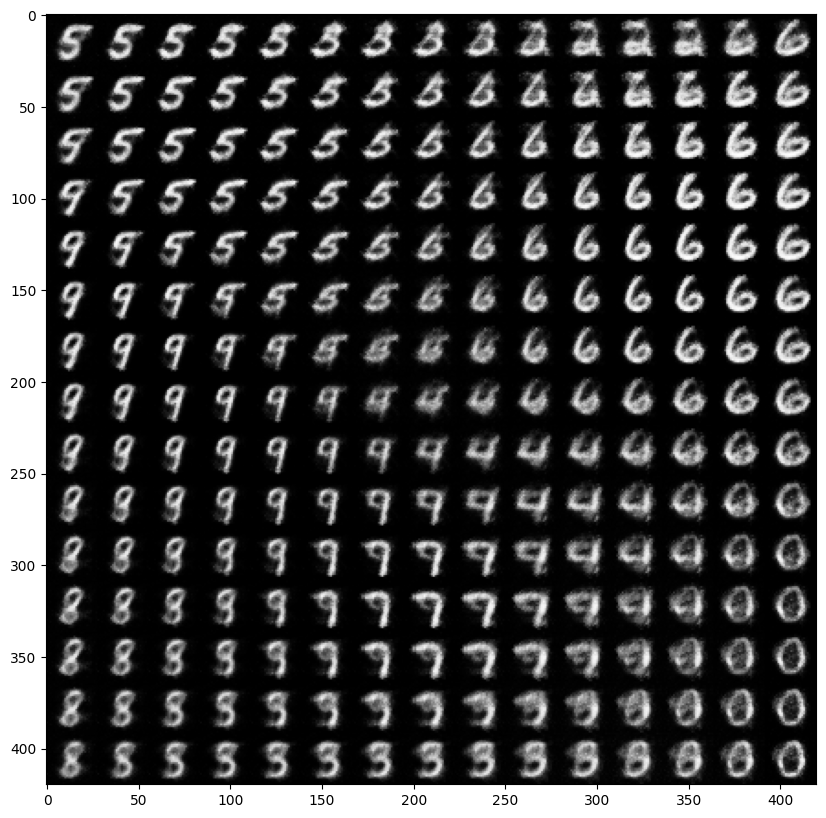

Epoch 31, Loss: 0.06687349826097488
Epoch 32, Loss: 0.06533883512020111
Epoch 33, Loss: 0.061998192220926285
Epoch 34, Loss: 0.06507465243339539
Epoch 35, Loss: 0.06634340435266495
Epoch 36, Loss: 0.062033627182245255
Epoch 37, Loss: 0.06100645288825035
Epoch 38, Loss: 0.053196195513010025
Epoch 39, Loss: 0.056927576661109924


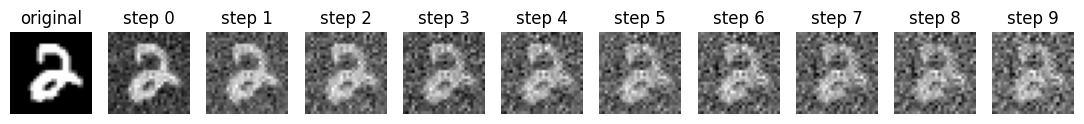

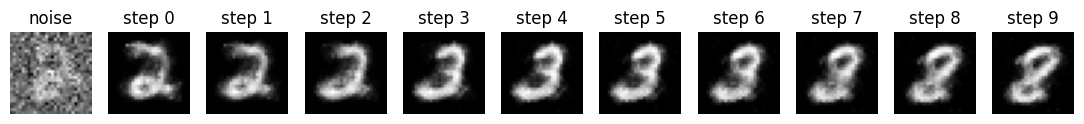

In [4]:
import numpy as np

def langevin_dynamics(x_0, var=0.9, n_steps=10, step_size=0.05):

    # 스코어 함수
    def score_fn(x):
        noisy_data = x + np.random.normal(0, var, size=x.size())
        return x - noisy_data

    x = x_0
    for i in range(n_steps):
        grad = score_fn(x)
        noise = np.random.normal(0, step_size, size=x.shape)
        x = x + step_size*grad + noise
    return torch.Tensor(x).float()

model = Diffusion().to(device)
train(model, langevin_dynamics, 40) #langevin_dynamics 로 훈련
# model.eval()

# 잡음 추가 및 재구성
origin, _ = next(iter(val_loader))
restore_images(model, origin, langevin_dynamics)

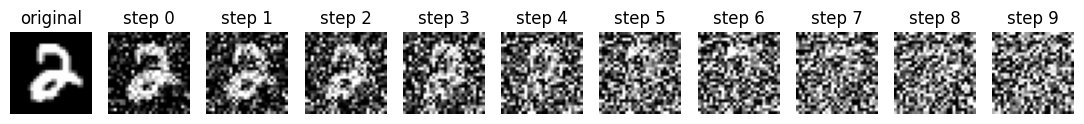

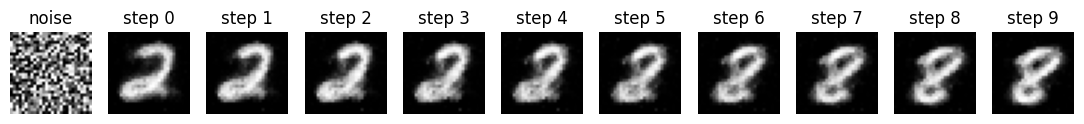

In [5]:
restore_images(model, origin, random_noise_fn)

In [6]:
# print(origin.shape)
# randnorm = torch.Tensor(np.random.normal(0, 1, size=origin.size()))
# origin_flat = randnorm.view(randnorm.size(0), -1)
# print(origin_flat[0].shape)
# origin_reconstructed = model(origin_flat, 9)
# print(origin_reconstructed.shape)

# for i in range(len(origin_reconstructed)):
#   plt.figure(figsize=(15,15))
#   display(origin_reconstructed[i].detach().numpy().reshape(28, 28), f'{i}', 1)

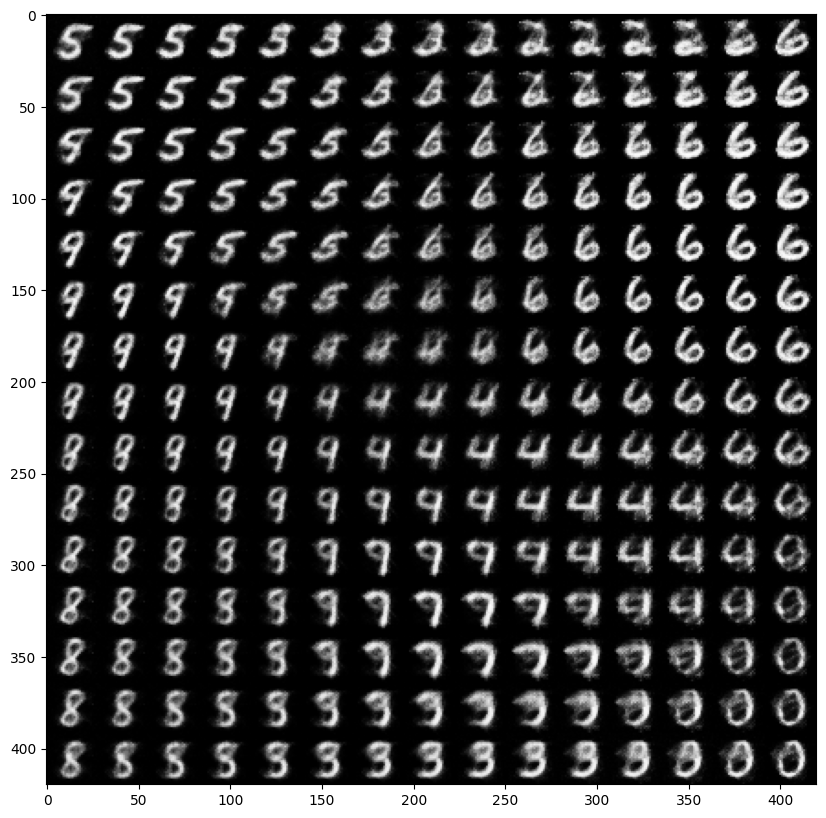

In [7]:
displayManifold()

MLE 평균 추정값: -0.10384651739409384
ELBO 평균 추정값: -0.10384650528430939


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

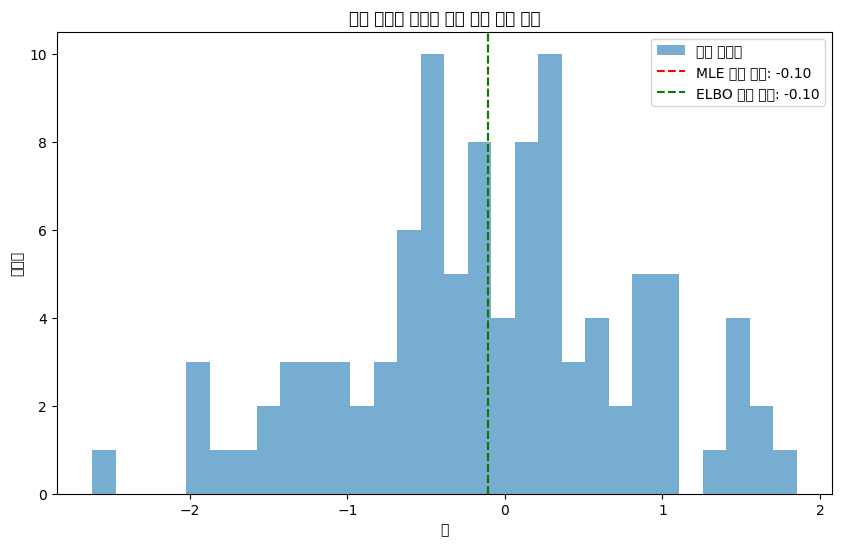

In [8]:
import numpy as np
import torch
from torch.distributions import Normal

# 데이터 생성
np.random.seed(42)
data = np.random.normal(0, 1, 100)  # 평균 0, 표준편차 1, 샘플 수 100

### 최대 우도 추정 (MLE)
mle_estimate = np.mean(data)
print(f"MLE 평균 추정값: {mle_estimate}")

### ELBO 추정
# 파라미터 초기화
mu = torch.tensor(1.0, requires_grad=True)  # 임의의 초기 평균 값
optimizer = torch.optim.Adam([mu], lr=0.1)  # 최적화 알고리즘 설정

# 데이터를 Tensor로 변환
data_tensor = torch.tensor(data, dtype=torch.float32)

# ELBO 최적화
for _ in range(1000):
    optimizer.zero_grad()
    # q(z) = N(mu, 1)로 가정
    q = Normal(mu, 1)
    # 로그 우도 계산
    log_likelihood = q.log_prob(data_tensor).sum()
    # ELBO는 여기서 로그 우도와 동일 (KL 항이 없음을 가정)
    # 실제 상황에서는 KL 발산 항을 추가해야 함
    loss = -log_likelihood
    loss.backward()
    optimizer.step()

print(f"ELBO 평균 추정값: {mu.item()}")

import matplotlib.pyplot as plt
# 실제 데이터 분포와 추정 결과를 시각화
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, alpha=0.6, label='실제 데이터')
plt.axvline(x=mle_estimate, color='red', linestyle='--', label=f'MLE 추정 평균: {mle_estimate:.2f}')
plt.axvline(x=mu.item(), color='green', linestyle='--', label=f'ELBO 추정 평균: {mu.item():.2f}')
plt.title('실제 데이터 분포와 평균 추정 결과 비교')
plt.xlabel('값')
plt.ylabel('빈도수')
plt.legend()
plt.show()


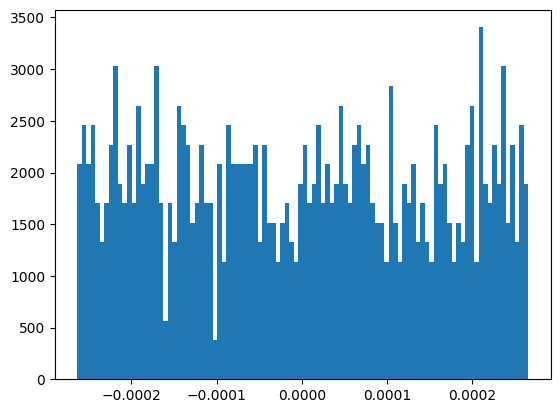

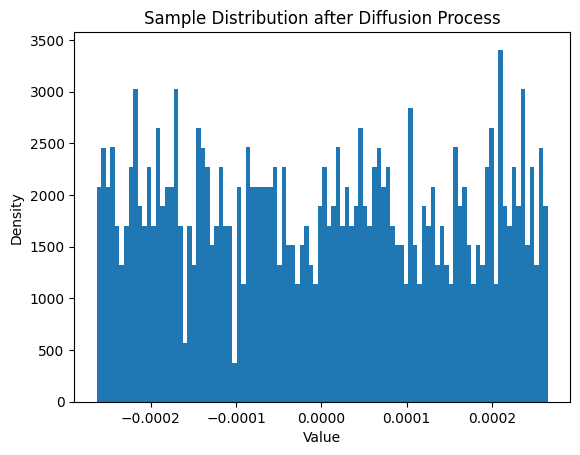

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 가상의 데이터 생성 함수
def generate_data(num_samples):
    return np.random.uniform(-10.0, 10.0, size=(num_samples,))

# 간단한 스코어 함수 예시 (실제 모델에서는 신경망을 통해 학습됩니다)
def score_function(x):
    return -x

# 디퓨전 프로세스 없이 스코어 기반 샘플링
def diffusion_process_without_langevin(steps, step_size, x):
    # 초기 샘플 생성

    # 스코어 기반 샘플링
    for step in range(steps):
        grad = score_function(x)  # 스코어 함수를 통한 그래디언트 계산
        x += step_size * grad  # 그래디언트 업데이트 (랑제뱅 동역학이 아닌 단순한 그래디언트 업데이트)

    return x

# 파라미터 설정
num_samples = 1000
steps = 100
step_size = 0.1

x = generate_data(num_samples)

# 디퓨전 프로세스 실행
final_samples = diffusion_process_without_langevin(steps, step_size, x)

# 결과 시각화
plt.hist(x, bins=100, density=True)
# plt.title('Sample Distribution after Diffusion Process')
# plt.xlabel('Value')
# plt.ylabel('Density')
plt.show()


# 결과 시각화
plt.hist(final_samples, bins=100, density=True)
plt.title('Sample Distribution after Diffusion Process')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()
